In [1]:
%load_ext autoreload
from mps.state import *

# TIME EVOLUTION

In [2]:
# file: mps/evolution.py

import numpy as np
import scipy.linalg
from numbers import Number
import mps.state
import scipy.sparse as sp
from mps.state import _truncate_vector, DEFAULT_TOLERANCE

Some of the commonly used operators:

In [3]:
# file: mps/evolution.py

σz = np.diag([1.0,-1.0])
i2 = np.identity(2)
σx = np.array([[0, 1], [1, 0]])
σy = -1j * σz @ σx

def creation_op(d):
    # Returns d dimensional cration operator
    return np.diag(np.sqrt(np.arange(1,d)),-1).astype(complex)

def annihilation_op(d):
    # Returns d dimensional cration operator
    return np.diag(np.sqrt(np.arange(1,d)),1).astype(complex)



## Nearest Neighbor Hamiltonians

TEBD is an algorithm that works with nearest-neighbor interaction Hamiltonians. These are Hamiltonian that can be written as follows,
$$
H = \sum_{i=0}^{N-2} h_{i,i+1}. 
$$
with pairwise Hamiltonian terms $h_{i,i+1}$ between neighbors on a 1D system.

`NNHamiltonian` is an abstract class that provides the interface to gather these pairwise interactions $h_{i,i+1}.$ It does not assume anything about the Hamiltonian: it may change in time, it may be precomputed or it may be computed on the fly. Children classes take care of that.

In [4]:
# file: mps/evolution.py

class NNHamiltonian(object):
    
    def __init__(self, size):
        #
        # Create a nearest-neighbor interaction Hamiltonian
        # of a given size, initially empty.
        #
        self.size = size
        self.constant = False

    def dimension(self, ndx):
        #
        # Return the dimension of the local Hilbert space
        #
        return 0
    
    def interaction_term(self, ndx, t=0.0):
        #
        # Return the interaction between sites (ndx,ndx+1)
        #
        return 0

### ConstantNNHamiltonian

The first implementation is one that assumes (i) a constant Hamiltonian that (ii) can be decomposed into local terms and product between local operators
$$
H = \sum_i O_i + \sum_i \sum_n L^{(n)}_i \otimes R^{(n)}_{i+1}
$$

In order to construct the pairwise terms $h_{i,i+1}$, we will split the local terms equally among pairs. More precisely, the local term on the i-th site appears with equal weights on $h_{i-1,i}$ and $h_{i,i+1},$ as follows
$$
h_{i,i+1} = \sum_n L^{(n)}_i \otimes R^{(n)}_{i+1} +
\begin{cases}
O_i + \frac{1}{2} O_{i+1}, \text{ if  } i = 0 \\
\frac{1}{2} O_i + O_{i+1}, \text{ if  } i = N-2 \\
\frac{1}{2} O_i + \frac{1}{2} O_{i+1}, \text{ else  } 
\end{cases}.
$$

The function below computes the interaction terms $h_{i,i+1}$:

In [5]:
# file: mps/evolution.py


class ConstantNNHamiltonian(NNHamiltonian):

    def __init__(self, size, dimension):
        #
        # Create a nearest-neighbor interaction Hamiltonian with fixed
        # local terms and interactions.
        #
        #  - local_term: operators acting on each site (can be different for each site)
        #  - int_left, int_right: list of L and R operators (can be different for each site)
        #
        super(ConstantNNHamiltonian, self).__init__(size)
        self.constant = True
        self.int_left = [[] for i in range(size-1)]
        self.int_right = [[] for i in range(size-1)]
        if isinstance(dimension, Number):
            dimension = [dimension] * size
        self.dimension_ = dimension

    def add_local_term(self, ndx, operator):
        #
        # Set the local term acting on the given site
        #
        if ndx == 0:
            self.add_interaction_term(ndx, operator, np.eye(self.dimension(1)))
        elif ndx == self.size-2:
            self.add_interaction_term(ndx, np.eye(self.dimension(ndx)), operator)
        else:
            self.add_interaction_term(ndx, np.eye(self.dimension(ndx)), 0.5*operator)
            self.add_interaction_term(ndx, 0.5*operator, np.eye(self.dimension(ndx+1)))

    def add_interaction_term(self, ndx, L, R):
        #
        # Add an interaction term $L \otimes R$ acting on sites 'ndx' and 'ndx+1'
        #
        # Add to int_left, int_right
        #
        # Update the self.interactions[ndx] term
        self.int_left[ndx].append(L)
        self.int_right[ndx].append(R)

    def dimension(self, ndx):
        return self.dimension_[ndx]

    def interaction_term(self, ndx, t=0.0):
        #for (L, R) in zip(self.int_left[ndx], self.int_right[ndx]):
            
        return sum([np.kron(L, R) for (L, R) in zip(self.int_left[ndx], self.int_right[ndx])])
    
    def constant(self):
        return True
            

A particular case would be a translationally invariant, constant Hamiltonian
$$H = \sum_i \left[O + \sum_n L^{(n)} \otimes R^{(n)}\right]_\text{site i}$$
which has the same local term $O$ on all sites, and the same interaction given by the product of $L^{(n)}$ left and $R^{(n)}$ right operators.

In [6]:
# file: mps/evolution.py

def make_ti_Hamiltonian(size, intL, intR, local_term=None):
    """Construct a translationally invariant, constant Hamiltonian with open
    boundaries and fixed interactions.
    
    Arguments:
    size        -- Number of sites in the model
    int_left    -- list of L (applied to site ndx) operators
    int_right   -- list of R (applied to site ndx + 1) operators
    local_term  -- operator acting on every site (optional)
    
    Returns:
    H           -- ConstantNNHamiltonian
    """
    if local_term is not None:
        dimension = len(local_term)
    else:
        dimension = len(intL[0])
    
    H = ConstantNNHamiltonian(size, dimension)
    H.local_term = local_term
    H.intL = intL
    H.intR = intR
    for ndx in range(size-1):
        for L,R in zip(H.intL, H.intR):
            H.add_interaction_term(ndx, L, R)
        if local_term is not None:
            H.add_local_term(ndx, local_term)
    return H

## Suzuki-Trotter Decomposition

In Suzuki-Trotter decomposition, the Hamiltonians of the nearest neighbor couplings can be decomposed into two non-commuting parts, $H_{\text{odd}} $ and $ H_{\text{even}} $, so that all additive 2-site operators in each part commute with each other.

Let us consider a simple example of tight binding model with on-site potential and decompose the Hamiltonian into 2-site terms, so that $H=\sum_i h_{i,i+1}$. 
\begin{equation}
h_{i,i+1} = \left(\frac{\omega}{2}  a_i^\dagger a_i \right) + \left(\frac{\omega}{2}  a_{i+1}^\dagger a_{i+1} \right) - \left( t a_{i}^\dagger a_{i+1} + \text{h.c.} \right).
\end{equation}
Since $[h_{i,i+1},h_{i+2,i+3}] = 0$, we can group these terms for even and odd $i$, so that $H = H_{\text{odd}} + H_{\text{even}} $. 

Note that the local term $ a_i^\dagger a_i$ appears only in one the groups for $i=1$ and $i=N$. Therefore we need to add two on-site terms $h_1 = \left(\frac{\omega}{2}  a_1^\dagger a_1 \right) $ and $h_N = \left(\frac{\omega}{2}  a_N^\dagger a_N \right) $, to the corresponding two-site terms. So that $h_{1,2} \rightarrow h_{1,2} + h_1$, and $h_{N-1,N} \rightarrow h_{N-1,N} + h_N$.

And for the first order Suzuki-Trotter decomposition, the evolution operator becomes
\begin{equation}
e^{-i \hat{H} \Delta t} = e^{-i \hat{H}_{\text{odd}} \Delta t}  e^{-i \hat{H}_{\text{even}} \Delta t} + O(\Delta t^2).
\end{equation}

`pairwise_unitaries` creates a list of Trotter unitarities corresponding to two-site operators, $U_{i,i+1} = e^{-i h_{i,i+1} \Delta t}$. The Trotter unitarities associated with $\hat{H}_{\text{odd}}$ and $\hat{H}_{\text{even}}$ are applied separately in consecutive sweeps depending on evenodd value passed to TEBD_sweep class:
$$ U = [U_{1,2}, U_{2,3}, U_{3,4}, \dots ]. $$


In [7]:
# file: mps/evolution.py


def pairwise_unitaries(H, δt):
    return [scipy.linalg.expm((-1j * δt) * H.interaction_term(k)).
                              reshape(H.dimension(k), H.dimension(k+1),
                                      H.dimension(k), H.dimension(k+1))
            for k in range(H.size-1)]

We apply each $U_{i,i+1} = e^{-i h_{i,i+1} \Delta t}$ to two neighbouring tensors, $A_i$ and $A_{i+1}$ simultaneously, as shown below.

<img src="fig_pdf/apply_mpo_to2site.svg" style="max-width: 90%; width: 35em">

The resulting tensor $B$ is a two-site tensor. We split this tensor using the canonical form algorithm defined in [this notebook](File%201c%20-%20Canonical%20form.ipynb). 

In [8]:
# file: mps/evolution.py


def apply_pairwise_unitaries(U, ψ, start, direction, tol=DEFAULT_TOLERANCE):
    """Apply the list of pairwise unitaries U onto an MPS state ψ in
    canonical form. Unitaries are applied onto pairs of sites (i,i+1),
    (i+2,i+3), etc. We start at 'i=start' and move in increasing or
    decreasing order of sites depending on 'direction'
    
    Arguments:
    U         -- List of pairwise unitaries
    ψ         -- State in canonical form
    start     -- First site for applying pairwise unitaries
    direction -- Direction of sweep.
    
    Returns:
    ψ         -- MPS in canonical form"""

    if direction > 0:
        ψ.recenter(start)
        for j in range(start, ψ.size-1, +2):
            AA = np.einsum('ijk,klm,prjl -> iprm', ψ[j], ψ[j+1], U[j])
            ψ.update_canonical_2site(AA, j, j+1, +1, tolerance=tol)
        if j == ψ.size-2:
            return ψ.size-3, -1
        else:
            return ψ.size-2, -1
    else:
        ψ.recenter(start)
        for j in range(start, -1, -2):
            AA = np.einsum('ijk,klm,prjl -> iprm', ψ[j], ψ[j+1], U[j])
            ψ.update_canonical_2site(AA, j, j+1, -1, tolerance=tol)
        if j == 0:
            return 1, +1
        else:
            return 0, +1

In [9]:
# file: mps/evolution.py


class TEBD_evolution(object):
    """TEBD_evolution is a class that continuously updates a quantum state ψ
    evolving it with a Hamiltonian H over intervals of time dt."""
    
    def __init__(self, ψ, H, dt, timesteps=1, order=1, tol=DEFAULT_TOLERANCE):
        """Create a TEBD algorithm to evolve a quantum state ψ with a fixed
        Hamiltonian H.
        
        Arguments:
        ψ         -- Quantum state to be updated. The class keeps a copy.
        H         -- NNHamiltonian for the evolution
        dt        -- Size of each Trotter step
        timesteps -- How many Trotter steps in each call to evolve()
        order     -- Order of the Trotter approximation (1 or 2)
        tol       -- Tolerance in MPS truncation
        """
        self.H = H
        self.dt = float(dt)
        self.timesteps = timesteps
        self.order = order
        self.tolerance = tol
        self.Udt = pairwise_unitaries(H, dt)
        if order == 2:
            self.Udt2 = pairwise_unitaries(H, dt/2)
        if not isinstance(ψ, mps.state.CanonicalMPS):
            ψ = mps.state.CanonicalMPS(ψ, center=0)
        else:
            ψ = ψ.copy()
        self.ψ = ψ
        if ψ.center <= 1:
            self.start = 0
            self.direction = +1
        else:
            self.start = ψ.size-2
            self.direction = -1

    def evolve(self, timesteps=None):
        """Update the quantum state with `timesteps` repetitions of the
        Trotter algorithms."""
        if timesteps is None:
            timesteps = self.timesteps
        for i in range(self.timesteps):
            #print(i)
            if self.order == 1:
                self.start, self.direction = apply_pairwise_unitaries(self.Udt, self.ψ, self.start, self.direction, tol=self.tolerance)
                self.start, self.direction = apply_pairwise_unitaries(self.Udt, self.ψ, self.start, self.direction, tol=self.tolerance)
            else:
                self.start, self.direction = apply_pairwise_unitaries(self.Udt, self.ψ, self.start, self.direction, tol=self.tolerance)
                self.start, self.direction = apply_pairwise_unitaries(self.Udt, self.ψ, self.start, self.direction, tol=self.tolerance)
                self.start, self.direction = apply_pairwise_unitaries(self.Udt, self.ψ, self.start, self.direction, tol=self.tolerance)
        return self.ψ

    def state():
        return self.ψ

## Error in Suzuki-Trotter decomposition

In the first order Suzuki-Trotter decomposition, evolution operator becomes
\begin{equation}
e^{-i \hat{H} \Delta t} = e^{-i \hat{H}_{\text{odd}} \Delta t}  e^{-i \hat{H}_{\text{even}} \Delta t} + O(\Delta t^2).
\end{equation}
Note that after $T/\Delta t$ time steps, the accumulated error is in the order of $\Delta t$.
Higher order Suzuki-Trotter decompositions can be used to reduce error.




# Tests

In [10]:
# file: mps/test/test_TEBD.py
from mps.evolution import *


In [11]:
# file: mps/test/test_TEBD.py
import unittest
import mps.state
import mps.tools
from mps.test.tools import *
import scipy.sparse as sp
import scipy.sparse.linalg

def random_wavefunction(n):
    ψ = np.random.rand(n) - 0.5
    return ψ / np.linalg.norm(ψ)

class TestTEBD_sweep(unittest.TestCase):
    
    def test_apply_pairwise_unitaries(self):
        N = 20
        tt = -np.pi/2
        ω = np.pi
        dt = 1e-3
        ψwave = random_wavefunction(N)
        ψ = CanonicalMPS(mps.state.wavepacket(ψwave))
        # We use the tight-binding Hamiltonian
        HMat = sp.diags([[tt,0]*(N//2), [ω]+[ω/2]*(N-2)+[ω], [tt,0]*(N//2)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        ψwave_final = sp.linalg.expm_multiply(-1j * dt * HMat, ψwave)
        
        H=make_ti_Hamiltonian(N, [tt * annihilation_op(2) ,tt * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)], 
                              local_term=ω*creation_op(2)@ annihilation_op(2))
        U = pairwise_unitaries(H, dt)
        start = 0
        direction = 1
        apply_pairwise_unitaries(U, ψ, start, direction, tol=DEFAULT_TOLERANCE)
        
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψ.tovector())))
        
                  
class TestTEBD_sweep(unittest.TestCase):
        
    def test_TEBD_evolution_first_order(self):
        #
        #
        #
        N = 19
        t = - np.pi/2
        ω = np.pi
        dt = 1e-6
        Nt = int(1000)
        #ψwave = random_wavefunction(N)
        xx=np.arange(N)
        x0 = int(N//2)
        w0 = 5
        k0 = np.pi/2

        ψwave = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx) 
        ψwave = ψwave / np.linalg.norm(ψwave) 
        ψmps = CanonicalMPS(mps.state.wavepacket(ψwave))
        # We use the tight-binding Hamiltonian
        H=make_ti_Hamiltonian(N, [t * annihilation_op(2) , t * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)], 
                              local_term=ω*creation_op(2)@ annihilation_op(2))
        #for i in range(Nt):
        #    
        #    ψmps = TEBD_sweep(H, ψmps, dt, 1, 0, tol=DEFAULT_TOLERANCE)
        #    ψmps = TEBD_sweep(H, ψmps, dt, -1, 1, tol=DEFAULT_TOLERANCE)
        ψmps = TEBD_evolution(ψmps, H, dt, timesteps=Nt, order=1, tol=DEFAULT_TOLERANCE).evolve()
        Hmat = sp.diags([[t]*(N), ω, [t]*(N)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        
        ψwave_final = sp.linalg.expm_multiply(-1j * dt*Nt * Hmat, ψwave)
        
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψmps.tovector())))
                
        
    def test_TEBD_evolution_second_order(self):
        #
        #
        #
        N = 21
        t = 0.1
        ω = 0.5
        dt = 1e-6
        Nt = int(1000)
        #ψwave = random_wavefunction(N)
        xx=np.arange(N)
        x0 = int(N//2)
        w0 = 5
        k0 = np.pi/2

        ψwave = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx) 
        ψwave = ψwave / np.linalg.norm(ψwave) 
        ψmps = CanonicalMPS(mps.state.wavepacket(ψwave))
        # We use the tight-binding Hamiltonian
        H=make_ti_Hamiltonian(N, [t * annihilation_op(2) , t * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)], 
                              local_term=ω*creation_op(2)@ annihilation_op(2))
        #for i in range(Nt):
        #    
        #    ψmps = TEBD_sweep(H, ψmps, dt, 1, 0, tol=DEFAULT_TOLERANCE)
        #    ψmps = TEBD_sweep(H, ψmps, dt, -1, 1, tol=DEFAULT_TOLERANCE)
        ψmps = TEBD_evolution(ψmps, H, dt, timesteps=Nt, order=2, tol=DEFAULT_TOLERANCE).evolve()
        Hmat = sp.diags([[t]*(N), ω, [t]*(N)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        
        ψwave_final = sp.linalg.expm_multiply(-1j * dt*Nt * Hmat, ψwave)
        
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψmps.tovector())))
                


    

In [12]:
%autoreload
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestTEBD_sweep'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_TEBD_evolution_first_order (__main__.TestTEBD_sweep) ... ok
test_TEBD_evolution_second_order (__main__.TestTEBD_sweep) ... FAIL

FAIL: test_TEBD_evolution_second_order (__main__.TestTEBD_sweep)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-11-370a8fae9bd1>", line 116, in test_TEBD_evolution_second_order
    abs(ψmps.tovector())))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 2 tests in 5.562s

FAILED (failures=1)


# Error Analysis

In [13]:
N = 19
tt = -np.pi/2
ω = np.pi

xx=np.arange(N)
x0 = int(N//2)
w0 = 5
k0 = np.pi/2

ψwave = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx) #random_wavefunction(N)
ψwave = ψwave / np.linalg.norm(ψwave) 
ψmps = CanonicalMPS(mps.state.wavepacket(ψwave))
# We use the tight-binding Hamiltonian
H=make_ti_Hamiltonian(N, [tt * annihilation_op(2) ,tt * creation_op(2)], 
                    [creation_op(2), annihilation_op(2)], 
                      local_term=ω*creation_op(2)@ annihilation_op(2))


## Truncation error:

In [14]:
dt = 1
U = pairwise_unitaries(H, dt)

HMat = sp.diags([[tt,0]*(N//2), [ω]+[ω/2]*(N-2)+[0], [tt,0]*(N//2)],
          offsets=[-1,0,+1],
          shape=(N,N),
          dtype=np.complex128)
ψwave_final = sp.linalg.expm_multiply(-1j * dt * HMat, ψwave)
exact_mps = mps.state.wavepacket(ψwave_final)

start = 0
direction = 1

In [15]:
# THE INTERACTION TERMS ARE CHECKED TO BE CORRECT
H.interaction_term(-1)/np.pi 

array([[ 0.0+0.j,  0.0+0.j,  0.0+0.j,  0.0+0.j],
       [ 0.0+0.j,  1.0+0.j, -0.5+0.j,  0.0+0.j],
       [ 0.0+0.j, -0.5+0.j,  0.0+0.j,  0.0+0.j],
       [ 0.0+0.j,  0.0+0.j,  0.0+0.j,  1.0+0.j]])

In [16]:
tol_list = 0.01*np.arange(100,1,-1) #[0.2, 1e-1, 4e-2, 1e-2, 1e-3, 1e-16]
overlap_list =[]
for tolerance in tol_list:
    ψ = ψmps.copy()
    apply_pairwise_unitaries(U, ψ, start, direction, tol=tolerance)
    overlap_list.append(abs(1-mps.expectation.scprod(exact_mps,ψ)))


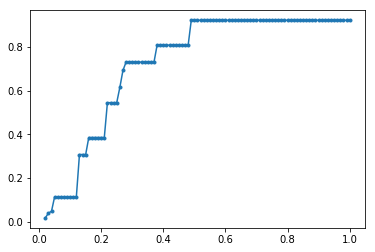

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tol_list, overlap_list, ".-")

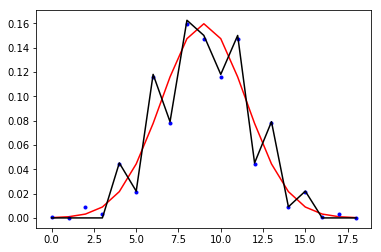

In [18]:
plt.plot(abs(ψwave)**2, "r-")
plt.plot(abs(ψwave_final)**2, "b.")
O = mps.evolution.creation_op(2)@ mps.evolution.annihilation_op(2)
plt.plot([abs(mps.expectation.expectation1_non_canonical(ψ, O, site)) for site in range(N)] , "k-")

## Error due to Trotter Decomposition:

In [19]:
Ntotal = 1

HMat = sp.diags([[tt]*(N), [ω]*(N), [tt]*(N)],
          offsets=[-1,0,+1],
          shape=(N,N),
          dtype=np.complex128)
ψwave_final = sp.linalg.expm_multiply(-1j * Ntotal * HMat, ψwave)
exact_mps = mps.state.wavepacket(ψwave_final)

start = 0
direction = 1

In [20]:
Nt_list = 100 * np.arange(1,5)
overlap_list = []
for Nt in Nt_list:
    dt = Ntotal/Nt
    ψ = ψmps.copy()
    ψ = TEBD_evolution(ψ, H, dt, timesteps=Nt, order=1, tol=DEFAULT_TOLERANCE).evolve()   
    overlap_list.append(abs(1-mps.expectation.scprod(exact_mps,ψ)))


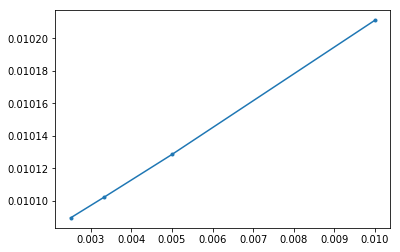

In [21]:
plt.plot(Ntotal/Nt_list, overlap_list, ".-")

/home/burcin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


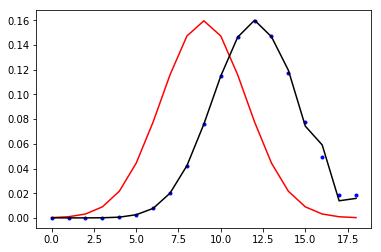

In [22]:
plt.plot(abs(ψwave)**2, "r-")
plt.plot(abs(ψwave_final)**2, "b.")
O = mps.evolution.creation_op(2)@ mps.evolution.annihilation_op(2)
plt.plot([mps.expectation.expectation1_non_canonical(ψ, O, site) for site in range(N)] , "k-")